# U-Net model implementation for images segmentation

In [1]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available

GPUs = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(GPUs))
for GPU in GPUs:
    tf.config.experimental.set_memory_growth(GPU, True)

Num GPUs Available:  1


In [ ]:
# Preparation of training set (images + masks):
# Spliting images and masks into smaller pieces (256x256 px)
# Original image size is about (9000x9000 px)
#
# The dataset (~1.5 GB) can be downloaded from the following site:
# https://landcover.ai.linuxpolska.com/#license

import glob
import os
import cv2

IMAGES_DIR = "DATA/images"
MASKS_DIR = "DATA/masks"
ROOT_DIR = "./TRAIN_SET"
OUTPUT_DIRS = ["IMAGES", "MASKS"]

TARGET_SIZE = 256

img_paths = glob.glob(os.path.join(IMAGES_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(MASKS_DIR, "*.tif"))

img_paths.sort()
mask_paths.sort()

os.makedirs(ROOT_DIR)
for output_dir in OUTPUT_DIRS:
    path = os.path.join(ROOT_DIR, output_dir, 'img')
    os.makedirs(path)

train_images_path = os.path.join(ROOT_DIR, OUTPUT_DIRS[0], 'img')
train_masks_path = os.path.join(ROOT_DIR, OUTPUT_DIRS[1], 'img')

for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                values, counts = np.unique(mask_tile, return_counts = True)
                print(values, counts)
                if not 0 in values:
                    out_img_path = os.path.join(train_images_path, "{}_{}.png".format(img_filename, k))
                    cv2.imwrite(out_img_path, img_tile)

                    out_mask_path = os.path.join(train_masks_path, "{}_{}.png".format(mask_filename, k))
                    cv2.imwrite(out_mask_path, mask_tile)
                else:
                    if (1 - (counts[0] / counts.sum())) > 0.05:
                        out_img_path = os.path.join(train_images_path, "{}_{}.png".format(img_filename, k))
                        cv2.imwrite(out_img_path, img_tile)

                        out_mask_path = os.path.join(train_masks_path, "{}_{}.png".format(mask_filename, k))
                        cv2.imwrite(out_mask_path, mask_tile)
            k += 1
    print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))

In [ ]:
# Preparation of test set (images + masks):
# Moving 1000 randomly selected images and it's coresponding mask
# from training set directory to the separated testing set directory

import random
import os

IMAGES_PATH = './TRAIN_SET/IMAGES/img'
MASKS_PATH = './TRAIN_SET/MASKS/img'
TEST_SET_PATH = './TEST_SET'
TEST_SET_DIRS = ['IMAGES', 'MASKS']

os.makedirs(TEST_SET_PATH)
for test_set_dir in TEST_SET_DIRS:
    path = os.path.join(TEST_SET_PATH, test_set_dir, 'img')
    os.makedirs(path)

TEST_IMAGES_PATH = os.path.join(TEST_SET_PATH, TEST_SET_DIRS[0], 'img')
TEST_MASKS_PATH = os.path.join(TEST_SET_PATH, TEST_SET_DIRS[1], 'img')

train_images = os.listdir(IMAGES_PATH)

for i in range(1000):
    train_images = os.listdir(IMAGES_PATH)
    test_image = random.choice(train_images)
    current_img_path = os.path.join(IMAGES_PATH, test_image)
    new_img_path = os.path.join(TEST_IMAGES_PATH, test_image)
    img_name = test_image.split('.')[0]
    current_mask_path = os.path.join(MASKS_PATH, '{}_m.png'.format(img_name))
    new_mask_path = os.path.join(TEST_MASKS_PATH, '{}_m.png'.format(img_name))
    os.replace(current_img_path, new_img_path)
    os.replace(current_mask_path, new_mask_path)

train_images_num = len(os.listdir(IMAGES_PATH))
train_masks_num = len(os.listdir(MASKS_PATH))

test_images_num = len(os.listdir(TEST_IMAGES_PATH))
test_masks_num = len(os.listdir(TEST_MASKS_PATH))

assert(train_images_num == train_masks_num and test_images_num == test_masks_num)
print('Test set created: [{}] images'.format(test_images_num))

In [3]:
# U-Net model weights checkpoint 

checkpoint_filepath = 'CHECKPOINT/MODEL_3'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True
)

In [4]:
# Preparation of data generators
# 20 % of training data will be taken for model validation

train_image_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect',
    validation_split = 0.2
)

train_mask_datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect',
    validation_split = 0.2
)

val_image_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    validation_split = 0.2
)

val_masks_datagen = ImageDataGenerator(
    validation_split = 0.2
)

test_image_datagen = ImageDataGenerator(
    rescale = 1 / 255
)

test_masks_datagen = ImageDataGenerator()

In [5]:
# Generators parameterization

IMAGES_PATH = 'TRAIN_SET/IMAGES'
MASKS_PATH = 'TRAIN_SET/MASKS'
TEST_IMAGES_PATH = 'TEST_SET/IMAGES'
TEST_MASKS_PATH = 'TEST_SET/MASKS'
IMG_SIZE = 256
BATCH_SIZE = 32
SEED_1 = 23
SEED_2 = 10
SEED_3 = 99

train_images_generator = train_image_datagen.flow_from_directory(
    directory = IMAGES_PATH,
    subset = 'training',
    seed = SEED_1,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    color_mode = 'rgb'
)

train_masks_generator = train_mask_datagen.flow_from_directory(
    directory = MASKS_PATH,
    subset = 'training',
    seed = SEED_1,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    color_mode = 'grayscale'
)

validation_images_generator = val_image_datagen.flow_from_directory(
    directory = IMAGES_PATH,
    subset = 'validation',
    seed = SEED_2,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    color_mode = 'rgb'
)

validation_masks_generator = val_masks_datagen.flow_from_directory(
    directory = MASKS_PATH,
    subset = 'validation',
    seed = SEED_2,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    color_mode = 'grayscale'
)

test_image_generator = test_image_datagen.flow_from_directory(
    directory = TEST_IMAGES_PATH,
    seed = SEED_3,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 1,
    class_mode = None,
    color_mode = 'rgb',
    shuffle = False
)

test_mask_generator = test_masks_datagen.flow_from_directory(
    directory = TEST_MASKS_PATH,
    seed = SEED_3,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 1,
    class_mode = None,
    color_mode = 'grayscale',
    shuffle = False
)

# Test data gnerator 
# Returns single set of data
# (image and it's coresponding mask)
test_generator = zip(test_image_generator, test_mask_generator)

Found 23919 images belonging to 1 classes.
Found 23919 images belonging to 1 classes.
Found 5979 images belonging to 1 classes.
Found 5979 images belonging to 1 classes.
Found 898 images belonging to 1 classes.
Found 898 images belonging to 1 classes.


In [6]:
# Function to generate batches of data.
# Masks will be One-Hot encoded.

def generator(image_generator, mask_generator):
    img_mask_generator = zip(image_generator, mask_generator)
    for (img, mask) in img_mask_generator:
        mask = tf.keras.utils.to_categorical(mask, 5)
        yield (img, mask)

In [7]:
# Training and Validation generators objects:

train_generator = generator(train_images_generator, train_masks_generator)
validation_generator = generator(validation_images_generator, validation_masks_generator)

In [ ]:
def display(display_list):
    plt.figure(figsize = (15, 15))

    title = ['Image', 'Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
        plt.axis('off')
    plt.show()

In [8]:
# U-Net model architecture
def unet_model(class_num = 5, img_height = 256, img_width = 256, img_channels = 3):
    inputs = Input((img_height, img_width, img_channels))

    c1 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(inputs)
    c1 = Dropout(rate = 0.1)(c1)
    c1 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
    p1 = MaxPooling2D(pool_size = (2, 2))(c1)

    c2 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = Dropout(rate = 0.1)(c2)
    c2 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
    p2 = MaxPooling2D(pool_size = (2, 2))(c2)

    c3 = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = Dropout(rate = 0.2)(c3)
    c3 = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
    p3 = MaxPooling2D(pool_size = (2, 2))(c3)

    c4 = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = Dropout(rate = 0.2)(c4)
    c4 = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
    p4 = MaxPooling2D(pool_size = (2, 2))(c4)

    c5 = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = Dropout(rate = 0.3)(c5)
    c5 = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

    u6 = Conv2DTranspose(filters = 128, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = Dropout(rate = 0.2)(c6)
    c6 = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)

    u7 = Conv2DTranspose(filters = 64, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = Dropout(rate = 0.2)(c7)
    c7 = Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)

    u8 = Conv2DTranspose(filters = 32, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = Dropout(rate = 0.1)(c8)
    c8 = Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

    u9 = Conv2DTranspose(filters = 16, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = Dropout(rate = 0.1)(c9)
    c9 = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)

    outputs = Conv2D(filters = class_num, kernel_size = (1, 1), activation = 'softmax')(c9)
    
    model = Model(inputs = [inputs], outputs = [outputs])

    return model

In [9]:
model = unet_model()

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [10]:
# Determination of model training and validation steps per 1 training epoch

import os
IMAGES_PATH = 'TRAIN_SET/IMAGES/img'
MASKS_PATH = 'TRAIN_SET/MASKS/img'

images_num = len(os.listdir(IMAGES_PATH))
masks_num = len(os.listdir(MASKS_PATH))

assert images_num == masks_num

training_steps = images_num * 0.8 // BATCH_SIZE
validation_steps = images_num * 0.2 // BATCH_SIZE
print("Training steps number: ", training_steps)
print("Validation steps number: ", validation_steps)

Training steps number:  747.0
Validation steps number:  186.0


In [11]:
# Model training

history = model.fit(
    train_generator,
    epochs = 40,
    steps_per_epoch = training_steps,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = [model_checkpoint_callback])

Epoch 1/40
747/747 [==============================] - 414s 492ms/step - loss: 0.8505 - accuracy: 0.6554 - val_loss: 0.6640 - val_accuracy: 0.7651
Epoch 2/40
747/747 [==============================] - 278s 367ms/step - loss: 0.4925 - accuracy: 0.8112 - val_loss: 0.5741 - val_accuracy: 0.7960
Epoch 3/40
747/747 [==============================] - 274s 367ms/step - loss: 0.4152 - accuracy: 0.8442 - val_loss: 0.5530 - val_accuracy: 0.8054
Epoch 4/40
747/747 [==============================] - 276s 369ms/step - loss: 0.3742 - accuracy: 0.8603 - val_loss: 0.5269 - val_accuracy: 0.8064
Epoch 5/40
747/747 [==============================] - 275s 368ms/step - loss: 0.3490 - accuracy: 0.8706 - val_loss: 0.4759 - val_accuracy: 0.8419
Epoch 6/40
747/747 [==============================] - 277s 371ms/step - loss: 0.3266 - accuracy: 0.8790 - val_loss: 0.4329 - val_accuracy: 0.8552
Epoch 7/40
747/747 [==============================] - 273s 365ms/step - loss: 0.3160 - accuracy: 0.8825 - val_loss: 0.4485 -

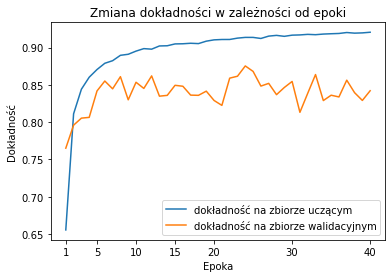

In [12]:
# Accuracy change plot during training

epochs = [i + 1 for i in range(40)]

plt.plot()

plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.xticks([1, 5, 10, 15, 20, 30, 40])
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.title('Zmiana dokładności w zależności od epoki')
plt.legend(['dokładność na zbiorze uczącym', 'dokładność na zbiorze walidacyjnym'])

plt.show()

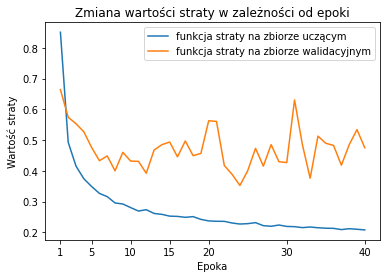

In [13]:
# Loss function change plot during training

plt.plot()

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xticks([1, 5, 10, 15, 20, 30, 40])
plt.xlabel('Epoka')
plt.ylabel('Wartość straty')
plt.title('Zmiana wartości straty w zależności od epoki')
plt.legend(['funkcja straty na zbiorze uczącym', 'funkcja straty na zbiorze walidacyjnym'])

plt.show()

In [270]:
# Load the best model weights

model.load_weights(checkpoint_filepath)

In [271]:
# Save the model

model.save('MODELS/CNN_MODEL_3_CP')

INFO:tensorflow:Assets written to: MODELS/CNN_MODEL_3_CP\assets


INFO:tensorflow:Assets written to: MODELS/CNN_MODEL_3_CP\assets


In [14]:
# Functions for:
#   - masks creating
#   - displaying results of predictions

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions():
        image, mask = test_generator.__next__()
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 21ms/step


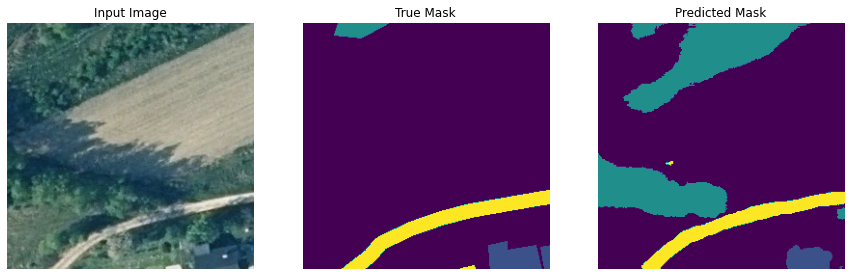

In [513]:
show_predictions()